In [75]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance, ImageOps
import os
import matplotlib.pyplot as plt
import tesserocr
from tesserocr import PyTessBaseAPI
import pytesseract
from IPython.display import HTML
import easyocr
import numpy as np

In [76]:
MANGA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manga"
MANHUA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manhua"
manga_images = os.listdir(MANGA_IMAGES_DIR)
manga_images_sorted = sorted(manga_images, key=lambda x: int(x.split("-")[0]))
manhua_images = os.listdir(MANHUA_IMAGES_DIR)
manhua_images_sorted = sorted(manhua_images, key=lambda x: int(x.split(".")[0]))
print("Manga Images in Sorted Order:\n", manga_images_sorted, "\n\n")
print("Manhua Images in Sorted Order:\n", manhua_images_sorted, "\n\n")

Manga Images in Sorted Order:
 ['1-66228d3b84417.jpg', '2-66228d3bf2943.jpg', '3-66228d3c5aabf.jpg', '4-66228d3cc2d25.jpg', '5-66228d3d3c3bb.jpg', '6-66228d3e4867b.jpg', '7-66228d3ea607f.jpg', '8-66228d3f18b74.jpg', '9-66228d3f86ce0.jpg', '10-66228d3ff178b.jpg', '11-66228d4068ea1.jpg', '12-66228d40d8238.jpg', '13-66228d413cc26.jpg', '14-66228d41eb36a.jpg', '15-66228d42618f9.jpg', '16-66228d4304b9d.jpg', '17-66228d43e3baf.jpg', '18-66228d446ca28.jpg', '19-66228d45515d9.jpg', '20-66228d4652066.jpg', '21-66228d4775e96.jpg', '22-66228d47f2f86.jpg', '23-66228d48cbb06.jpg', '24-66228d49555f8.jpg', '25-66228d49dcbc0.jpg', '26-66228d4a57dd5.jpg', '27-66228d4ad3bae.jpg', '28-66228d4b56a0b.jpg', '29-66228d4c2fa21.jpg', '30-66228d4d2b01b.jpg'] 


Manhua Images in Sorted Order:
 ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', 

In [77]:
def preprocess_image(img):
    img = (
        img.convert("L")
        .resize([3 * _ for _ in img.size], Image.BICUBIC)
        .point(lambda p: p > 75 and p + 100)
    )
    return img

    # # Apply a binary threshold
    # threshold = 128
    # binary_img = img.point(lambda p: 255 if p > threshold else 0)

    # return binary_img

    # # Convert to grayscale
    # img = img.convert("L")

    # # Apply a median filter for noise reduction
    # img = img.filter(ImageFilter.MedianFilter(size=3))

    # # Enhance contrast
    # enhancer = ImageEnhance.Contrast(img)
    # img = enhancer.enhance(2)  # Adjust this value as needed

    # # Apply binary thresholding
    # img = img.point(lambda p: 255 if p > 128 else 0)

    # # Convert to numpy array for morphological operations
    # img_np = np.array(img)

    # # Apply dilation and erosion (morphological operations)
    # img_np = ImageOps.invert(
    #     Image.fromarray(img_np)
    # )  # Invert colors for morphological operations
    # img_np = img_np.filter(ImageFilter.MinFilter(3))  # Dilation
    # img_np = img_np.filter(ImageFilter.MaxFilter(3))  # Erosion

    # # Convert back to binary
    # img_np = ImageOps.invert(img_np)
    # img_np = img_np.point(lambda p: 255 if p > 128 else 0)

    # # Convert back to PIL image
    # processed_img = Image.fromarray(np.array(img_np))

    # return processed_img


def pil_to_cv2(img):
    # Convert the PIL image to RGB mode (assuming it's not already)
    rgb_image = img.convert("RGB")
    # Get the image data as a NumPy array
    open_cv_image = np.array(rgb_image)

    # Convert color space from RGB (PIL) to BGR (OpenCV)
    return cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)


def drawImage(img, bboxes=[], scalling_factor=1.0, threashold=70.0):
    if img.mode == "L":
        img = img.convert("RGB")
    draw = ImageDraw.Draw(img)
    font_path = os.path.join(r"C:\Windows\Fonts", "simsun.ttc")
    font = ImageFont.truetype(font_path, size=20)
    for box in bboxes:
        x1, y1, x2, y2, text, conf = (
            box["x1"],
            box["y1"],
            box["x2"],
            box["y2"],
            box["text"],
            box["conf"],
        )
        if conf <= threashold:
            continue
        draw.rectangle(((x1, y1), (x2, y2)), outline=(0, 255, 0), width=2)
        draw.text(
            (x1, y1 - 10),
            text,
            font=font,
            fill=(255, 0, 0),
            stroke_width=0,
        )
        draw.text(
            (x1, y1 - 30),
            f"{conf:.0f}",
            font=font,
            fill=(0, 0, 255),
            stroke_width=1,
        )
    display(img.resize(int(scalling_factor * s) for s in img.size))


def drawImageFile(image_path, bboxes=[], scalling_factor=1.0, threashold=70.0):
    image = Image.open(image_path)

    drawImage(image, bboxes, scalling_factor, threashold)


def use_tessorocr(image_path, lang="eng"):
    # img = Image.open(image_path)

    img = preprocess_image(image_path)

    with PyTessBaseAPI(lang=lang) as api:  # type:ignore
        api.SetImage(img)

        print(api.GetUTF8Text())
        print(api.AllWordConfidences())


def use_pytesseract(
    image_path,
    lang="eng",
    config="--oem 1 --psm 3",
    scalling_factor=1.0,
    threashold=70.0,
    do_preprocess=False,
):

    img = Image.open(image_path)
    if do_preprocess:
        img = preprocess_image(img)

    ocr_text = pytesseract.image_to_string(img, lang=lang, config=config)

    print("Text Output: \n\n------------\n", ocr_text, "\n")
    data = pytesseract.image_to_data(img, lang=lang, config=config).split("\n")[1:]
    temp_boxes = []
    for d in data:
        tmp_d = d.split("\t")
        if len(tmp_d) > 1:
            temp_boxes.append(
                {
                    "level": int(tmp_d[0]),
                    "page_num": int(tmp_d[1]),
                    "block_num": int(tmp_d[2]),
                    "par_num": int(tmp_d[3]),
                    "line_num": int(tmp_d[4]),
                    "word_num": int(tmp_d[5]),
                    "x1": int(tmp_d[6]),
                    "y1": int(tmp_d[7]),
                    "x2": int(tmp_d[6]) + int(tmp_d[8]),
                    "y2": int(tmp_d[7]) + int(tmp_d[9]),
                    "width": int(tmp_d[8]),
                    "height": int(tmp_d[9]),
                    "conf": float(tmp_d[10]) if tmp_d[10] else 0.0,
                    "text": tmp_d[11],
                }
            )
    drawImage(img, temp_boxes, scalling_factor, threashold)


def use_EasyOCR(
    image_path, lang, scalling_factor=1.0, threashold=70.0, do_preprocess=False
):
    img = Image.open(image_path)
    if do_preprocess:
        img = preprocess_image(img)
    reader = easyocr.Reader(["en", lang])
    data = reader.readtext(np.array(img) if img.mode == "L" else img)
    tmp_text = ""
    tmp_boxes = []
    for box in data:
        tmp_data = {}
        tmp_coords, text, conf = box
        if len(tmp_coords) > 3:
            x1, y1, x2, y2 = (
                tmp_coords[0][0],
                tmp_coords[0][1],
                tmp_coords[2][0],
                tmp_coords[2][1],
            )
            tmp_data["x1"], tmp_data["y1"], tmp_data["x2"], tmp_data["y2"] = (
                x1,
                y1,
                x2,
                y2,
            )
        tmp_data["text"] = text
        tmp_data["conf"] = conf * 100
        tmp_boxes.append(tmp_data)
        tmp_text += text + "\n"
    print("\n Extracted Text:\n\n", tmp_text)
    drawImage(
        img, bboxes=tmp_boxes, scalling_factor=scalling_factor, threashold=threashold
    )


 Extracted Text:

 と
1
.



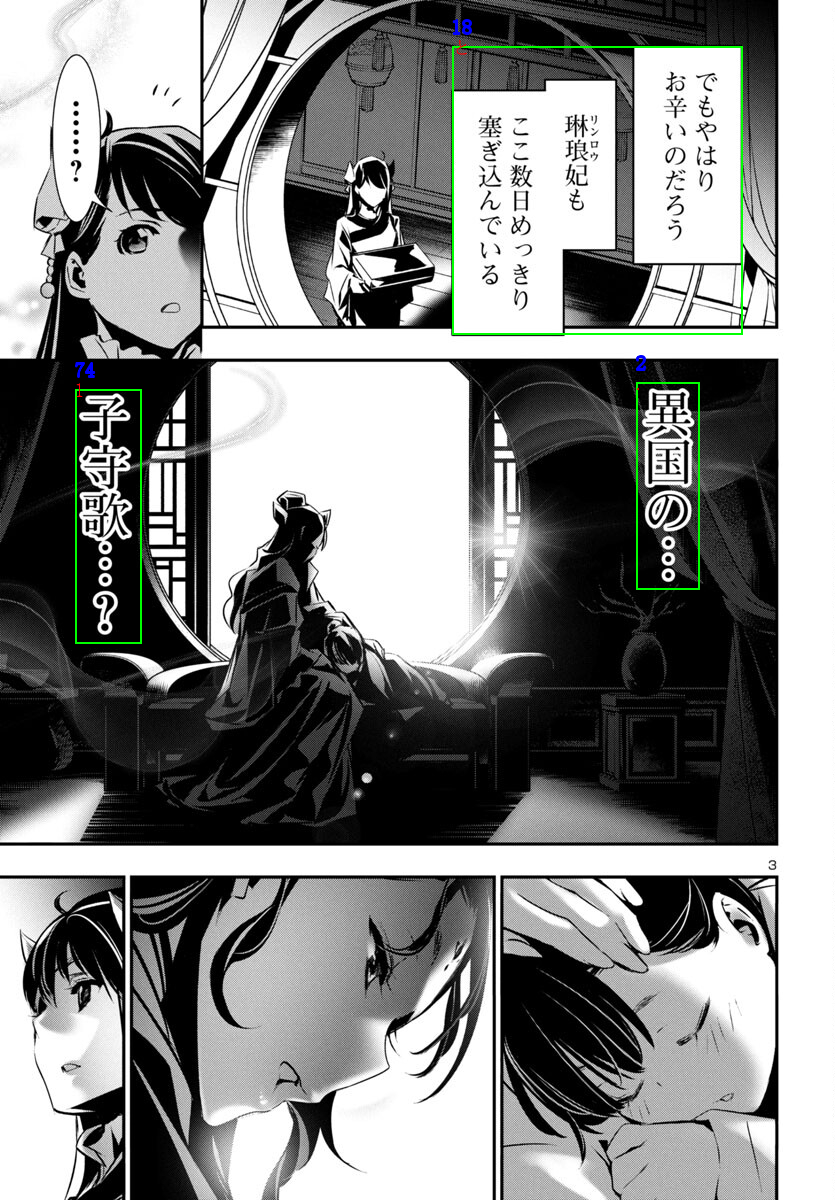

In [79]:
img_idx = 7
mode = "manhua"
ocr_tool = "easyocr"
LANG = "eng"
if mode == "manhua":
    if ocr_tool == "easyocr":
        LANG = "ch_sim"
    elif ocr_tool == "tesseract":
        LANG = "chi_sim"
elif mode == "manga":
    if ocr_tool == "easyocr":
        LANG = "ja"
    elif ocr_tool == "tesseract":
        LANG = "jpn"

image_path = (
    os.path.join(MANHUA_IMAGES_DIR, manhua_images_sorted[img_idx])
    if mode == "manhua"
    else os.path.join(MANGA_IMAGES_DIR, manga_images_sorted[img_idx])
)
# use_tessorocr(image_path, lang="chi_sim")
# use_pytesseract(image_path, lang=LANG, config="--oem 1 --psm 6", threashold=50.0)
use_EasyOCR(
    image_path, lang=LANG, threashold=0.0, scalling_factor=1.0, do_preprocess=False
)